# Flow predictor

Data processing, model training and analysis

In [5]:
%matplotlib widget
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RadioButtons

## Data pre-processing

In [6]:
# Initialise DataFrame and discard non-numeric data
initial_df = pd.read_excel("data.xlsx", header=[0, 1], index_col=0)

initial_df.columns = initial_df.columns.set_levels(["rain", "flow"], level=0)
initial_df = initial_df.rename_axis(index="date")

initial_df = initial_df.apply(pd.to_numeric, errors="coerce")
initial_df = initial_df[initial_df >= 0]
initial_df["rain"] = initial_df["rain"][initial_df["rain"]<=279]
initial_df.dropna(inplace=True)

df = initial_df
df = df[np.abs(df - df.std()) <= df.mean() + 3 * df.std()]


df.dropna(inplace=True)


## Data visualization


================== INITIAL DATA ==================

              flow                                                  rain                                       
         Crakehill  Skip Bridge     Westwick      Skelton Arkengarthdale  East Cowton  Malham Tarn  Snaizeholme
count  1450.000000  1450.000000  1450.000000  1450.000000    1450.000000  1450.000000  1450.000000  1450.000000
mean     19.518869     7.598130    21.493799    46.959175       5.788138     5.298759    13.996138     9.642483
std      25.257463    10.016639    28.272770    55.706370      13.266413    12.300429    25.051795    20.940650
min       2.060000     1.002000     1.954000     3.694000       0.000000     0.000000     0.000000     0.000000
25%       5.230000     2.157750     5.623250    12.382500       0.000000     0.000000     0.000000     0.000000
50%      10.050000     3.487000    10.354500    24.245000       0.800000     0.000000     1.600000     0.800000
75%      21.675000     8.813000    26.686000    59.

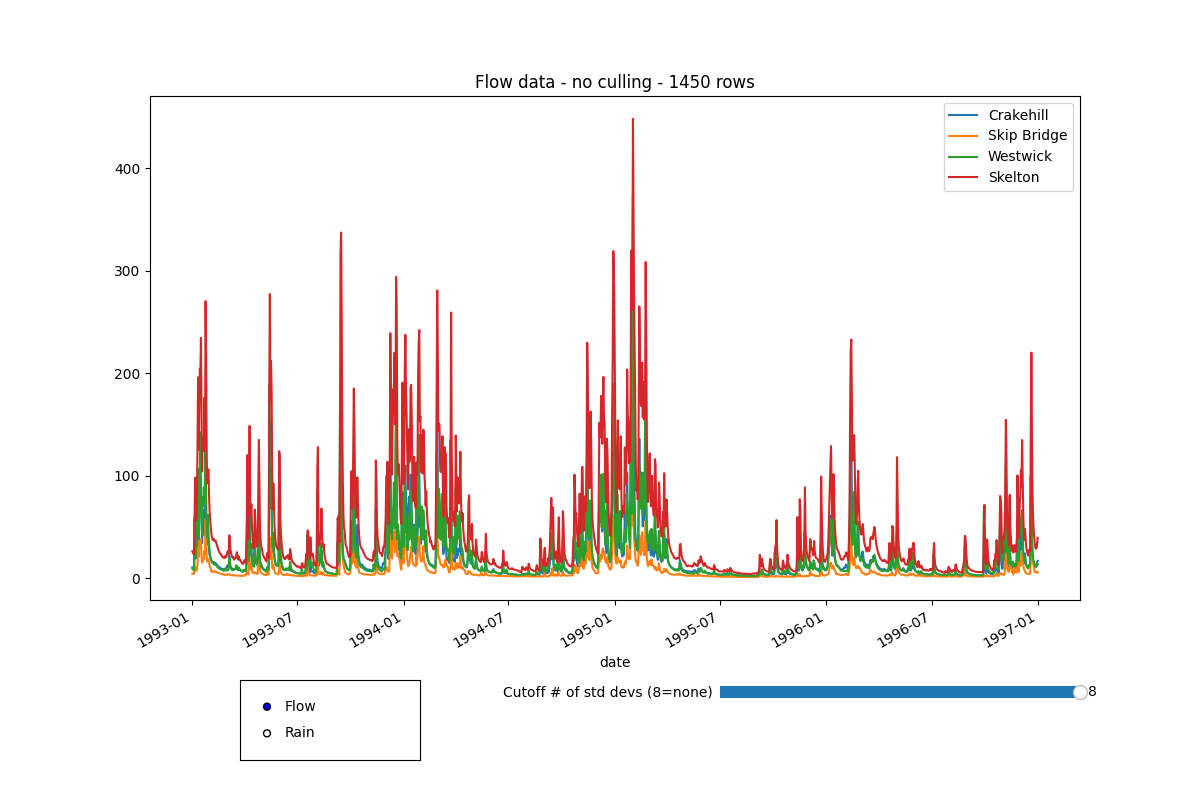

In [16]:
plt.close("all")

print("\n================== INITIAL DATA ==================\n")
print(initial_df.describe().to_string())

print("\n================== CULLING BY STD DEVS ==================\n")

# Line graph showing flow/rain datasets after culling with different std dev values

# Initial graph - flow data with no culling
fig, ax_graph = plt.subplots()
ax_buttons = fig.add_axes([0.2, 0.05, 0.15, 0.1])
ax_slider = fig.add_axes([0.6, 0.12, 0.3, 0.03])
initial_df["flow"].plot(ax=ax_graph, title=f"Flow data - no culling - {initial_df.shape[0]} rows")



# Radio buttons for flow/rain

dataset_radio = RadioButtons(ax=ax_buttons, labels=["Flow", "Rain"])



# Slider for # of std devs

sd_slider = Slider(ax=ax_slider, label="Cutoff # of std devs (8=none)",
                   valmin=1, valmax=8, valinit=8, valstep=1)


def update(val):
    dataset = dataset_radio.value_selected
    sd = sd_slider.val

    data = initial_df
    title_text = f"{dataset} data - no culling - {data.shape[0]} rows"
    if sd != 8:
        data = data[np.abs(data - data.std()) <= data.mean() + sd * data.std()]
        data.dropna(inplace=True)
        title_text = f"{dataset} data - culling values >{sd} std devs from mean - {data.shape[0]} rows"

    ax_graph.clear()
    data[dataset.lower()].plot(ax=ax_graph, title=title_text)
    fig.subplots_adjust(bottom=0.25)
    fig.canvas.draw()


dataset_radio.on_clicked(update)
sd_slider.on_changed(update)



# Figure styling
fig.subplots_adjust(bottom=0.25)
fig.set_size_inches((12, 8))
fig.canvas.header_visible = False